# Pràctica 2
### Autors:
<ul>
    <li>Gerard Medina</li>
    <li>Xisco Cerdó</li>
</ul>

## Imports

In [19]:
import os
import shutil
import torch
import torch.nn 
import torch.optim
from tqdm import tqdm
from torchvision import transforms, datasets
import matplotlib.pyplot as plt # to plot examples from the dataset
%matplotlib inline


## Classificar el Dataset

In [3]:
# Set the path to the dataset directory
old_dataset = "data/old_pets/images/"

# Set the paths for the output directories
carpeta_moixos = "data/pets/CNN/moix/"
carpeta_cans = "data/pets/CNN/ca/"

# Create the output directories if they don't exist
os.makedirs(carpeta_moixos, exist_ok=True)
os.makedirs(carpeta_cans, exist_ok=True)

# Get the list of all files in the dataset directory
all_files = os.listdir(old_dataset)

# Loop through each file and copy it to the appropriate directory
for filename in all_files:
    full_path = os.path.join(old_dataset, filename)
    if filename[0].islower():
        shutil.copy(full_path, os.path.join(carpeta_cans, filename))
    elif filename[0].isupper():
        shutil.copy(full_path, os.path.join(carpeta_moixos, filename))

## Carregar el Dataset

In [4]:
new_dataset = "data/pets/CNN/"

# Define the transformations to be applied to the dataset
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load the dataset
dataset = datasets.ImageFolder(root=new_dataset, transform=transform)

# Define the data loader
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

## Mostrar exemples nou Dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Number of images in dataset:  7390


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

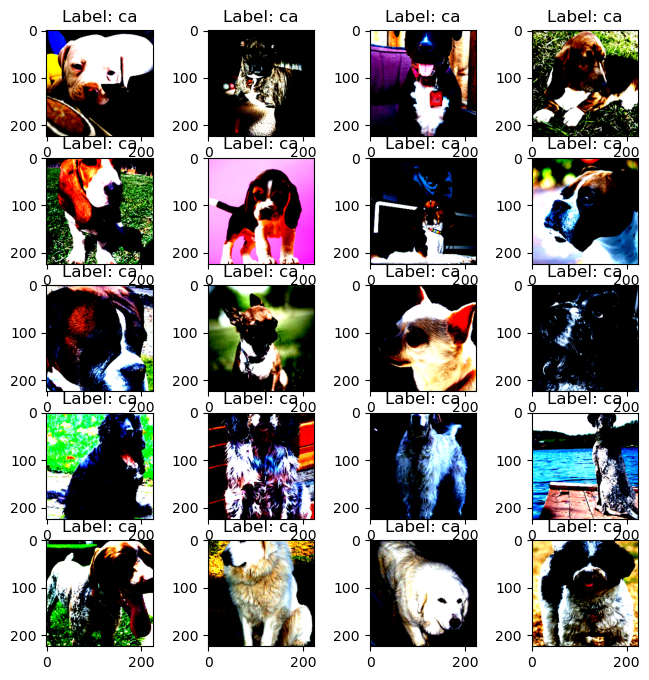

In [5]:
# Print the length of the dataset
print("Number of images in dataset: ", len(dataset))

# Show some sample images
fig=plt.figure(figsize=(8, 8))
columns = 4
rows = 5
for i in range(1, columns*rows +1):
    img_idx = i*100
    img, label = dataset[img_idx]
    fig.add_subplot(rows, columns, i)
    plt.title("Label: "+dataset.classes[label])
    plt.imshow(img.permute(1, 2, 0))
plt.show()

# Build the Model


In [8]:

class PetCNN(torch.nn.Module):
    def __init__(self, num_classes=37):
        super(PetCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.relu1 = torch.nn.ReLU()
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = torch.nn.ReLU()
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.relu3 = torch.nn.ReLU()
        self.pool3 = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = torch.nn.Linear(28*28*128, 512)
        self.relu4 = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(512, num_classes)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.pool3(x)
        x = x.view(-1, 28*28*128)
        x = self.fc1(x)
        x = self.relu4(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [6]:
train_size = round(int(len(dataset)*.75))
test_size = len(dataset)-train_size
train_set, val_set = torch.utils.data.random_split(dataset, [train_size,test_size])

In [9]:
# Set the GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PetCNN().to(device)

In [11]:
# training hyperparameters
batch_size = 64
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20

In [12]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [14]:
def train(model, dataloader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
        loss.backward()
        optimizer.step()
    
    epoch_loss = running_loss / len(dataloader.dataset)
    epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
    
    return epoch_loss, epoch_acc

In [15]:
# Train the model
train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

best_valid_acc = 0.0  # variable to keep track of the best validation accuracy so far

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer)
    valid_loss, valid_acc = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    valid_losses.append(valid_loss)
    valid_accs.append(valid_acc)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4f}")
          
    if valid_acc > best_valid_acc:
        best_valid_acc = valid_acc
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_losses': train_losses,
            'train_accs': train_accs,
            'valid_losses': valid_losses,
            'valid_accs': valid_accs
        }
        torch.save(checkpoint, 'pet_checkpoint.pt')

100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch 1/20, Train Loss: 0.8343, Train Acc: 0.6416, Valid Loss: 0.6208, Valid Acc: 0.6710


100%|██████████| 29/29 [00:13<00:00,  2.14it/s]


Epoch 2/20, Train Loss: 0.5821, Train Acc: 0.6983, Valid Loss: 0.5498, Valid Acc: 0.7035


100%|██████████| 29/29 [00:12<00:00,  2.35it/s]


Epoch 3/20, Train Loss: 0.5310, Train Acc: 0.7301, Valid Loss: 0.5179, Valid Acc: 0.7278


100%|██████████| 29/29 [00:12<00:00,  2.41it/s]


Epoch 4/20, Train Loss: 0.4812, Train Acc: 0.7705, Valid Loss: 0.5325, Valid Acc: 0.7359


100%|██████████| 29/29 [00:12<00:00,  2.40it/s]


Epoch 5/20, Train Loss: 0.4106, Train Acc: 0.8114, Valid Loss: 0.5739, Valid Acc: 0.7284


100%|██████████| 29/29 [00:16<00:00,  1.77it/s]


Epoch 6/20, Train Loss: 0.3555, Train Acc: 0.8446, Valid Loss: 0.5123, Valid Acc: 0.7581


100%|██████████| 29/29 [00:12<00:00,  2.28it/s]


Epoch 7/20, Train Loss: 0.2678, Train Acc: 0.8872, Valid Loss: 0.5972, Valid Acc: 0.7689


100%|██████████| 29/29 [00:12<00:00,  2.35it/s]


Epoch 8/20, Train Loss: 0.1834, Train Acc: 0.9269, Valid Loss: 0.6676, Valid Acc: 0.7706


100%|██████████| 29/29 [00:12<00:00,  2.35it/s]


Epoch 9/20, Train Loss: 0.1140, Train Acc: 0.9580, Valid Loss: 0.7676, Valid Acc: 0.7592


100%|██████████| 29/29 [00:12<00:00,  2.37it/s]


Epoch 10/20, Train Loss: 0.0567, Train Acc: 0.9800, Valid Loss: 0.9083, Valid Acc: 0.7765


100%|██████████| 29/29 [00:13<00:00,  2.22it/s]


Epoch 11/20, Train Loss: 0.0477, Train Acc: 0.9830, Valid Loss: 1.0521, Valid Acc: 0.7765


100%|██████████| 29/29 [00:12<00:00,  2.32it/s]


Epoch 12/20, Train Loss: 0.0404, Train Acc: 0.9856, Valid Loss: 1.3047, Valid Acc: 0.7673


100%|██████████| 29/29 [00:13<00:00,  2.09it/s]


Epoch 13/20, Train Loss: 0.0253, Train Acc: 0.9922, Valid Loss: 1.1383, Valid Acc: 0.7668


100%|██████████| 29/29 [00:12<00:00,  2.33it/s]


Epoch 14/20, Train Loss: 0.0149, Train Acc: 0.9962, Valid Loss: 1.3196, Valid Acc: 0.7722


100%|██████████| 29/29 [00:12<00:00,  2.39it/s]


Epoch 15/20, Train Loss: 0.0171, Train Acc: 0.9951, Valid Loss: 1.3331, Valid Acc: 0.7722


100%|██████████| 29/29 [00:12<00:00,  2.36it/s]


Epoch 16/20, Train Loss: 0.0116, Train Acc: 0.9971, Valid Loss: 1.5292, Valid Acc: 0.7814


100%|██████████| 29/29 [00:12<00:00,  2.33it/s]


Epoch 17/20, Train Loss: 0.0102, Train Acc: 0.9971, Valid Loss: 1.5091, Valid Acc: 0.7587


100%|██████████| 29/29 [00:12<00:00,  2.35it/s]


Epoch 18/20, Train Loss: 0.0179, Train Acc: 0.9949, Valid Loss: 1.4294, Valid Acc: 0.7641


100%|██████████| 29/29 [00:12<00:00,  2.30it/s]


Epoch 19/20, Train Loss: 0.0129, Train Acc: 0.9969, Valid Loss: 1.5115, Valid Acc: 0.7792


100%|██████████| 29/29 [00:12<00:00,  2.37it/s]

Epoch 20/20, Train Loss: 0.0127, Train Acc: 0.9966, Valid Loss: 1.4585, Valid Acc: 0.7689


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

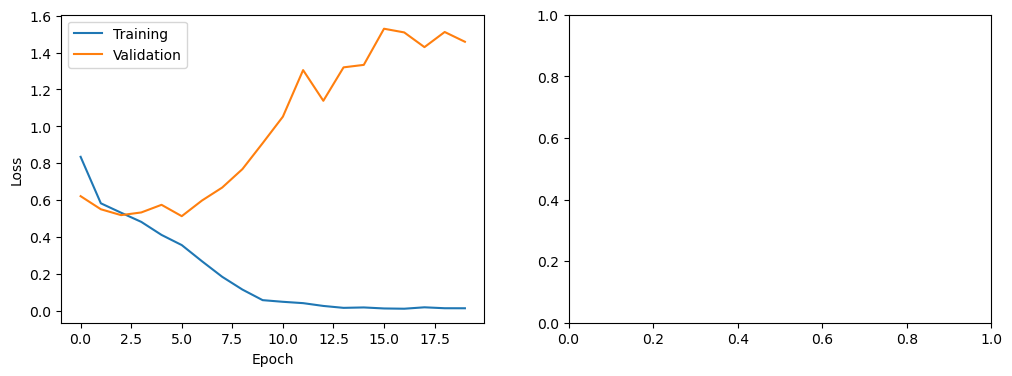

In [20]:
# Plot the training and validation losses and accuracies
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training')
plt.plot(valid_losses, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Training')
plt.plot(valid_accs, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()